# **Summary of Moving Least Squares (MLS) Method**

## **Introduction**
The **Moving Least Squares (MLS) method** is a meshless approximation technique used for function interpolation and numerical analysis. Unlike finite element or finite difference methods, MLS does not require a predefined mesh, making it highly flexible for irregular geometries and adaptive refinement.

## **Key Concepts**
### **1. Approximation Function**
MLS constructs an approximation of a function $ f(x) $ in the form:

$$
f(x) = \sum_{i=1}^{m} p_i(x) a_i(x)
$$

where:
- $ p_i(x) $ are basis functions (e.g., monomials from a Pascal triangle expansion).
- $ a_i(x) $ are coefficients that minimize a weighted least squares error.

### **2. Pascal Triangle Basis Functions**
The basis functions are selected from a **2D Pascal Triangle** up to second-order terms:

$$
p(x, y) = \begin{bmatrix} 1, & x - x_0, & y - y_0, & (x - x_0)^2, & (x - x_0)(y - y_0), & (y - y_0)^2 \end{bmatrix}^T
$$

This basis includes:
- **Constant term**: $ 1 $
- **Linear terms**: $ x - x_0 $, $ y - y_0 $
- **Quadratic terms**: $ (x - x_0)^2 $, $ (x - x_0)(y - y_0) $, $ (y - y_0)^2 $

These polynomials ensure local smoothness and accuracy in function approximation.

### **3. Weighting Function**
A weight function $ w(x) $ is introduced to ensure that nearby points influence the approximation more than distant points. A common choice is the **Gaussian weight function**:

$$
w(x) = e^{-\left(\frac{|x - x_i|}{d_i}\right)^2}
$$

where $ d_i $ is a characteristic distance defining the influence zone.

In the code, **30 nearest neighbors** are used for each evaluation point. The radius of influence is determined dynamically using the distance to the **30th nearest neighbor**.

### **4. Normal Equation System**
The MLS method determines the unknown coefficients $ a_i(x) $ by solving:

$$
A(x) a(x) = B(x) f
$$

where:
- $ A(x) $ is the **moment matrix**, formed from basis functions and weight functions.
- $ B(x) $ is a matrix related to the weight function and sample points.
- $ f $ is the vector of function values at known sample points.

### **5. Derivatives Computation**
Once the **shape functions** are computed, derivatives (gradients, Hessians) can be found using:

$$
\frac{\partial f}{\partial x} = \sum_{i=1}^{m} \frac{\partial p_i(x)}{\partial x} a_i(x)
$$

This allows MLS to be used for solving **partial differential equations (PDEs)**.

## **Implementation Details**
- Our **Python implementation** uses **30 nearest neighbors** for each evaluation point.
- The **moment matrix** is regularized using the **pseudo-inverse** (`pinv`) to handle potential singularities.
- **Shape functions** and their derivatives are computed and stored as sparse matrices.
- The condition number of $ A(x) $ is recorded to monitor numerical stability.

## **Advantages of MLS**
✅ **Meshless**: No need for predefined connectivity between points.  
✅ **High Accuracy**: Smooth and continuous function representation.  
✅ **Adaptability**: Can handle complex geometries and irregular point distributions.  
✅ **Locality Control**: Influence is restricted to a fixed number of nearest neighbors (30 in this case).  

## **Applications**
🔹 Computational Fluid Dynamics (CFD)  
🔹 Structural Analysis (Meshfree methods like SPH)  
🔹 Image Processing (Interpolation, Denoising)  
🔹 Machine Learning (Kernel-Based Regression)  

---
**References:**  
- Liu, G.R. (2003). Meshfree Methods: Moving Beyond the Finite Element Method. *CRC Press*.


## **Code Availability**
⚠️ **This method has been used in the following research paper:**  
➡ **Boutopoulos, Ioannis D., et al. "Two-phase biofluid flow model for magnetic drug targeting." Symmetry 12.7 (2020): 1083.**  

📌 **If you want access to the implementation codes from the paper, please let me know.** 

---

# **Implementation** 

In [7]:
import numpy as np
import scipy as sp
import shutil
import os
from numpy.linalg import cond, pinv
from sklearn.neighbors import NearestNeighbors
import itertools
import time 
import matplotlib.pyplot as plt

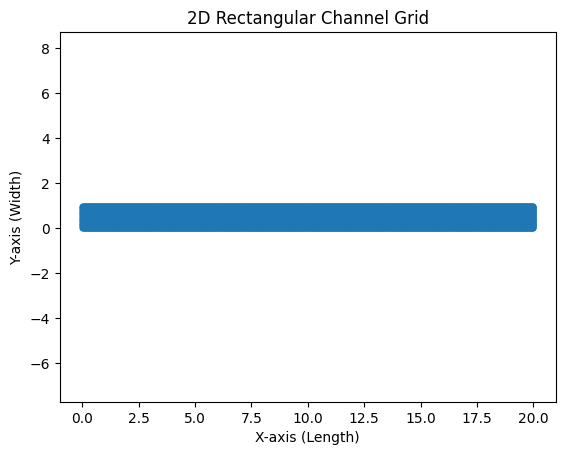

In [8]:
# Create a rectangular 2D channel with length = 20 and width = 1
H = 1        # Channel width
L = 20.0     # Channel length
ny = 50      # Number of points in the vertical (y) direction
nx = 1000    # Number of points in the horizontal (x) direction

# Generate evenly spaced points along the x and y axes
x = np.linspace(0, L, nx)  # X-coordinates from 0 to L
y = np.linspace(0, H, ny)  # Y-coordinates from 0 to H

# Create a meshgrid of coordinates
X, Y = np.meshgrid(x, y)

# Reshape the meshgrid into a list of (x, y) coordinate pairs
X = np.reshape(X, (ny * nx, 1))
Y = np.reshape(Y, (ny * nx, 1))
nodes = np.hstack((X, Y))  # Combine X and Y into a single array

# Save the generated points to a file
np.savetxt('geom.dat', nodes)

# Plot the generated grid points to visualize the domain
plt.plot(nodes[:, 0], nodes[:, 1], '.')
plt.xlabel("X-axis (Length)")
plt.ylabel("Y-axis (Width)")
plt.title("2D Rectangular Channel Grid")
plt.axis('equal')
plt.show()

Based on the above geometry we will calculate the Moving Least Squares.

In [9]:
# Define polynomial basis degree (quadratic basis)
md = 6  

# Create directory for storing MLS shape functions
dirpath = os.path.join('MLS')
if os.path.exists(dirpath):
    shutil.rmtree(dirpath)
os.makedirs('MLS')

# Lists to store results
cond_number = list()  # Store condition number of moment matrix A

i_list = []
sdi_list = []
sf_list = []
sfx_list = []
sfxx_list = []
sfy_list = []
sfyy_list = []

# Define polynomial basis functions using Pascal's triangle up to quadratic terms
w = np.array(([1], [0], [0], [0], [0], [0]))      # Weight function w(x)
pdx = np.array(([0], [1], [0], [0], [0], [0]))    # ∂/∂x basis
pdxx = np.array(([0], [0], [0], [2], [0], [0]))   # ∂²/∂x² basis
pdy = np.array(([0], [0], [1], [0], [0], [0]))    # ∂/∂y basis
pdyy = np.array(([0], [0], [0], [0], [0], [2]))   # ∂²/∂y² basis

# Transpose for later matrix operations
w_ = w.transpose()
pdx_ = pdx.transpose()
pdxx_ = pdxx.transpose()
pdy_ = pdy.transpose()
pdyy_ = pdyy.transpose()

# Load node coordinates from geometry file
distnod = np.genfromtxt('geom.dat')

# Find the 30 nearest neighbors for each node using a ball-tree algorithm
nbrs = NearestNeighbors(n_neighbors=30, algorithm='ball_tree').fit(distnod)
distances, indices = nbrs.kneighbors(distnod)

# Compute support radius a0 based on the 30th nearest neighbor distance
a1 = distances[:, 29]  
a0 = 0.3 * a1  # Scaling factor for kernel width


start_iter_time = time.time()

# Loop over all nodes to compute MLS shape functions
for i in range(len(distnod)):
    if i%10000 == 0: # Print progress
        print(i)
    
    # Extract the 30 nearest neighbor coordinates for the current node
    nsd = distnod[indices[i, :]]

    # Construct the local polynomial basis matrix p_
    p_ = np.array([
        np.ones(len(nsd)),                 # Constant term (1)
        nsd[:, 0] - nsd[0, 0],             # Linear term x
        nsd[:, 1] - nsd[0, 1],             # Linear term y
        (nsd[:, 0] - nsd[0, 0]) ** 2,      # Quadratic term x²
        (nsd[:, 0] - nsd[0, 0]) * (nsd[:, 1] - nsd[0, 1]),  # Mixed term xy
        (nsd[:, 1] - nsd[0, 1]) ** 2       # Quadratic term y²
    ])

    # Compute weight function values (Gaussian kernel)
    Dn = np.exp(-((distances[i, :]) / a0[i]) ** 2)
    
    # Compute first and second derivatives of the weight function
    Dx = (-2 / (a0[i] ** 2)) * (nsd[0, 0] - nsd[:, 0]) * Dn
    Dxx = (-2 / (a0[i] ** 4)) * (a0[i] ** 2 - 2 * (nsd[0, 0] - nsd[:, 0]) ** 2) * Dn
    Dy = (-2 / (a0[i] ** 2)) * (nsd[0, 1] - nsd[:, 1]) * Dn
    Dyy = (-2 / (a0[i] ** 4)) * (a0[i] ** 2 - 2 * (nsd[0, 1] - nsd[:, 1]) ** 2) * Dn

    # Compute moment matrix A and its derivatives
    A = p_.dot(np.diag(Dn).dot(p_.T))
    Ax = p_.dot(np.diag(Dx).dot(p_.T))
    Axx = p_.dot(np.diag(Dxx).dot(p_.T))
    Ay = p_.dot(np.diag(Dy).dot(p_.T))
    Ayy = p_.dot(np.diag(Dyy).dot(p_.T))

    # Compute B matrix (used for shape function calculation)
    B = np.diag(Dn).dot(p_.T)
    Bx = np.diag(Dx).dot(p_.T)
    Bxx = np.diag(Dxx).dot(p_.T)
    By = np.diag(Dy).dot(p_.T)
    Byy = np.diag(Dyy).dot(p_.T)

    # Compute the inverse of A using the pseudo-inverse
    IA = pinv(A)

    # Compute derivatives of the inverse of A using matrix identities
    IAx = -IA.dot(Ax).dot(IA)
    IAxx = -IAx.dot(Ax).dot(IA) - IA.dot(Axx).dot(IA) - IA.dot(Ax).dot(IAx)
    IAy = -IA.dot(Ay).dot(IA)
    IAyy = -IAy.dot(Ay).dot(IA) - IA.dot(Ayy).dot(IA) - IA.dot(Ay).dot(IAy)

    # Store condition number of A (for numerical stability analysis)
    cond_number.append(cond(A))

    # Compute MLS shape functions and their derivatives
    sf_list.append(np.ravel((w_.dot(IA).dot(B.T)).T).tolist())  # Convert to list explicitly
    sfx_list.append(np.ravel(((pdx_.dot(IA) + w_.dot(IAx)).dot(B.T) + w_.dot(IA).dot(Bx.T)).T).tolist())
    sfy_list.append(np.ravel(((pdy_.dot(IA) + w_.dot(IAy)).dot(B.T) + w_.dot(IA).dot(By.T)).T).tolist())
    sfxx_list.append(np.ravel(((pdxx_.dot(IA) + 2*pdx_.dot(IAx) + w_.dot(IAxx)).dot(B.T)
                     +( w_.dot(IAx) + 2*pdx_.dot(IA) + w_.dot(IAx)).dot(Bx.T)
                     +w_.dot(IA).dot(Bxx.T)).T).tolist())

    sfyy_list.append(np.ravel((((pdyy_.dot(IA)) +2*pdy_.dot(IAy) + w_.dot(IAyy)).dot(B.T)
                   +(w_.dot(IAy) + 2*pdy_.dot(IA) + w_.dot(IAy)).dot(By.T)
                   +w_.dot(IA).dot(Byy.T)).T).tolist())

    # Store index mapping for sparse matrix assembly
    i_list.append(i * np.ones((len(nsd))))

# Flatten lists for sparse matrix construction
sdi_list = (indices.tolist())
sf_list = list(itertools.chain(*sf_list))
sfx_list = list(itertools.chain(*sfx_list))
sfy_list = list(itertools.chain(*sfy_list))
sfxx_list = list(itertools.chain(*sfxx_list))
sfyy_list = list(itertools.chain(*sfyy_list))

i_list = list(itertools.chain(*i_list))
sdi_list = list(itertools.chain(*sdi_list))

# Construct sparse matrices for shape functions and their derivatives
sf = sp.sparse.csc_matrix((sf_list, (i_list, sdi_list)), shape=(len(distnod), len(distnod)))
sfx = sp.sparse.csc_matrix((sfx_list, (i_list, sdi_list)), shape=(len(distnod), len(distnod)))
sfxx = sp.sparse.csc_matrix((sfxx_list, (i_list, sdi_list)), shape=(len(distnod), len(distnod)))
sfy = sp.sparse.csc_matrix((sfy_list, (i_list, sdi_list)), shape=(len(distnod), len(distnod)))
sfyy = sp.sparse.csc_matrix((sfyy_list, (i_list, sdi_list)), shape=(len(distnod), len(distnod)))

# Save results
np.savez('MLS/shape_functions.npz', sf=sf, sfx=sfx, sfy=sfy, sfxx=sfxx, sfyy=sfyy)

iter_time = time.time() - start_iter_time
print(f"For the calculation of {i+1} nodes it took {iter_time:.4f} seconds.")



0
10000
20000
30000
40000
For the calculation of 50000 nodes it took 15.0741 seconds.
